In [1]:
from __future__ import unicode_literals
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle

In [2]:
MODEL_1 = "finetuned"
MODEL_2 = "irishman"

SET_1_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_1)
SET_2_CALCULATED_METRICS_PATH = "data/evaluation/results/{}_vs_{}/{}_calculated_metrics.pkl".format(MODEL_1, MODEL_2, MODEL_2)

ABSOLUTE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/absolute_metrics_statistics.pkl".format(MODEL_1, MODEL_2)
RELATIVE_METRICS_STATISTICS_PATH = "data/evaluation/results/{}_vs_{}/relative_metrics_statistics.pkl".format(MODEL_1, MODEL_2)

## Results finetuned vs irishman

Load calculated metrics for each model

In [3]:
with open(SET_1_CALCULATED_METRICS_PATH, "rb") as f:
    set1_loaded_results = pickle.load(f)

with open(SET_2_CALCULATED_METRICS_PATH, "rb") as f:
    set2_loaded_results = pickle.load(f)

display("Set 1 ({}): {} samples".format(MODEL_1, len(set1_loaded_results)))
display("Set 2 ({}): {} samples".format(MODEL_2, len(set2_loaded_results)))

u'Set 1 (finetuned): 9 samples'

u'Set 2 (irishman): 9 samples'

We calculated the following metrics:

**Pitch-based features**
- total_used_pitch
- total_pitch_class_histogram
- pitch_class_transition_matrix
- pitch_range
- avg_pitch_shift

**Rhythm-based features**
- total_used_note
- avg_IOI
- note_length_hist
- note_length_transition_matrix

In [4]:
display(set1_loaded_results.keys())

['total_used_note',
 'note_length_transition_matrix',
 'total_pitch_class_histogram',
 'total_used_pitch',
 'avg_IOI',
 'avg_pitch_shift',
 'pitch_range',
 'pitch_class_transition_matrix',
 'note_length_hist']

# Pitch-based features

## Feature: `total_used_pitch`

### O que faz:
Esta função conta quantas alturas (pitches) diferentes foram utilizadas em uma música MIDI, medindo a diversidade melódica.

### Como funciona (passo a passo):
1. `piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)`
    - Converte o MIDI em uma matriz piano roll (128 x tempo)
    - 128 linhas = todas as notas possíveis (C0 até G9)
    - Cada coluna = um momento no tempo (100 fps)
    - Valores > 0 = nota está sendo tocada
    
2. `sum_notes = np.sum(piano_roll, axis=1)`
    - Soma cada linha (pitch) ao longo do tempo
    - Resultado: vetor de 128 elementos
    - Cada elemento = tempo total que aquela nota foi tocada

3. `used_pitch = np.sum(sum_notes > 0)`
    - Conta quantas notas tiveram sum > 0
    - Ou seja: quantas alturas diferentes foram usadas na música

### Exemplo prático:
```
Se uma música usa as notas: C4, D4, C4, E4, D4, C4, E3

piano_roll teria valores > 0 apenas nas linhas 52, 60, 62, 64 (MIDI numbers)

sum_notes[52] = tempo total de E3
sum_notes[60] = tempo total de C4
sum_notes[62] = tempo total de D4  
sum_notes[64] = tempo total de E4
sum_notes[outros] = 0

Resultado: total_used_pitch = 4 (quatro alturas diferentes)
```

### Ponto importante:
A função conta alturas únicas, não repetições:

- **C4 repetido 3x** = conta como 1 altura única
- **D4 repetido 2x** = conta como 1 altura única
- **E4 usado 1x** = conta como 1 altura única
- **E3 usado 1x** = conta como 1 altura única

**Total = 4 alturas diferentes**

### Diferença importante:
**total_used_pitch**: Quantas alturas diferentes (foco melódico)
**total_used_note**: Quantos eventos de nota (foco rítmico)
**total_pitch_class_histogram**: Proporção de cada classe (C, C#, D...)

### Interpretação musical:
- **Valores baixos (5-15)**: Melodias simples, poucas notas diferentes
- **Valores médios (20-40)**: Melodias moderadamente complexas
- **Valores altos (50+)**: Melodias muito diversas, muitas alturas diferentes

Esta métrica é útil para comparar a riqueza melódica entre os modelos.

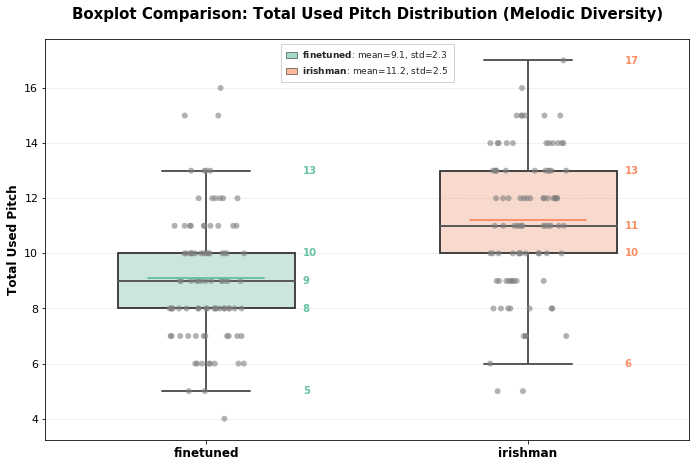

In [5]:
# Dados para total_used_pitch
data1_pitch = set1_loaded_results['total_used_pitch'].flatten()
data2_pitch = set2_loaded_results['total_used_pitch'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df_pitch = pd.DataFrame({
    'value': np.concatenate([data1_pitch, data2_pitch]),
    'model': np.array([labels[0]] * len(data1_pitch) + [labels[1]] * len(data2_pitch))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df_pitch, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df_pitch[df_pitch['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means_pitch = df_pitch.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means_pitch[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats_pitch = df_pitch.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df_pitch.loc[df_pitch['model'] == lbl, 'value'].values
    q1 = float(qstats_pitch.loc[lbl, 0.25])
    med = float(qstats_pitch.loc[lbl, 0.50])
    q3 = float(qstats_pitch.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda centralizada no topo em 2 linhas
stds_pitch = df_pitch.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats_pitch = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means_pitch[labels[0]]), float(stds_pitch[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means_pitch[labels[1]]), float(stds_pitch[labels[1]]))
]
handles_pitch = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
                 Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles_pitch, label_stats_pitch, loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Pitch', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Pitch Distribution (Melodic Diversity)', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

## Feature: `total_used_note`

### O que faz:
Esta função conta o número total de notas utilizadas em uma música MIDI, focando apenas na quantidade de eventos de nota (aspecto rítmico), não nas alturas específicas.

### Como funciona:
- **Input**: Recebe um `feature` (que contém o padrão MIDI) e `track_num` (número da faixa, padrão = 1)
- **Processo**:
    - Percorre todos os eventos na faixa MIDI especificada
    - Para cada evento, verifica se é um NoteOnEvent (início de nota)
    - Além disso, verifica se `data[1] != 0 (velocity ≠ 0, garantindo que não é um "note off" disfarçado)`
    - Cada nota válida incrementa o contador used_notes
- **Output**: Retorna um escalar representando o número total de notas na música

### Diferença importante:
- `total_used_note`: Conta quantas notas foram tocadas (foco rítmico)
- `total_used_pitch`: Conta quantas alturas/pitches diferentes foram usadas (foco melódico)

### Exemplo prático:
Se uma música tem as notas: C, C, D, C, E
- `total_used_note` = 5 (cinco eventos de nota)
- `total_used_pitch` = 3 (três pitches distintos: C, D, E)

Essa métrica é útil para analisar a densidade rítmica e complexidade temporal das composições geradas pelos diferentes modelos.

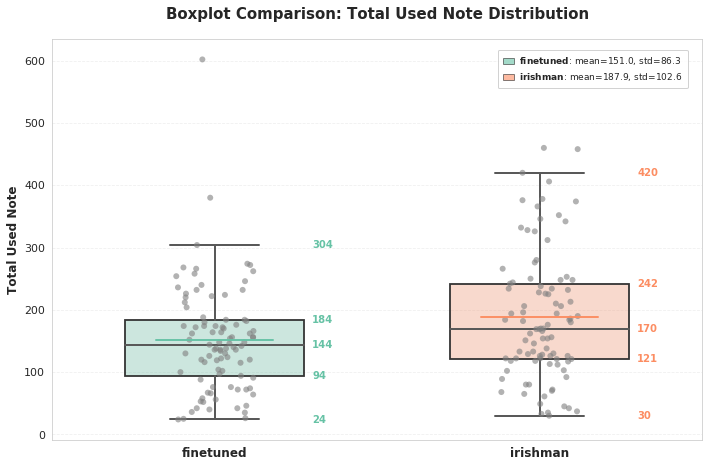

In [6]:
# Dados
data1 = set1_loaded_results['total_used_note'].flatten()
data2 = set2_loaded_results['total_used_note'].flatten()

# Figura e estilo
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style('whitegrid')

# Cores e rótulos
colors = ['#66c2a5', '#fc8d62']
labels = [MODEL_1, MODEL_2]
order = labels
pos_map = {lbl: i for i, lbl in enumerate(order)}

# Dados em formato long
df = pd.DataFrame({
    'value': np.concatenate([data1, data2]),
    'model': np.array([labels[0]] * len(data1) + [labels[1]] * len(data2))
})

# Boxplot (sem outliers)
sns.boxplot(x='model', y='value', data=df, ax=ax, palette=colors,
            width=0.55, showfliers=False, linewidth=2, saturation=0.8,
            order=order)

for artist in ax.artists:
    fc = artist.get_facecolor()
    artist.set_facecolor((fc[0], fc[1], fc[2], 0.35))  # mais transparente
    artist.set_edgecolor('#333333')
    artist.set_linewidth(1.8)

# Pontos (stripplot) com maior visibilidade - em cinza
for lbl, c in zip(labels, colors):
    sns.stripplot(x='model', y='value', data=df[df['model'] == lbl], ax=ax,
                  color='gray', size=6.0, jitter=0.12, alpha=0.6, linewidth=0,
                  order=order, zorder=4)

# Linha da média com a cor do box (acima dos pontos)
means = df.groupby('model')['value'].mean()
for lbl, c in zip(labels, colors):
    x = pos_map[lbl]
    m = float(means[lbl])
    ax.plot([x - 0.18, x + 0.18], [m, m], color=c, linewidth=2, alpha=0.95, zorder=5)

# Quartis e limites (whiskers) 1.5*IQR
qstats = df.groupby('model')['value'].quantile([0.25, 0.5, 0.75]).unstack()
for lbl, c in zip(labels, colors):
    vals = df.loc[df['model'] == lbl, 'value'].values
    q1 = float(qstats.loc[lbl, 0.25])
    med = float(qstats.loc[lbl, 0.50])
    q3 = float(qstats.loc[lbl, 0.75])
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr
    # whiskers conforme definição do boxplot
    lw = float(np.min(vals[vals >= lower_fence])) if np.any(vals >= lower_fence) else float(np.min(vals))
    uw = float(np.max(vals[vals <= upper_fence])) if np.any(vals <= upper_fence) else float(np.max(vals))

    # Anotações numéricas à direita, mais afastadas do box
    x = pos_map[lbl] + 0.30
    ax.text(x, uw, '{:.0f}'.format(uw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q3, '{:.0f}'.format(q3), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, med, '{:.0f}'.format(med), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, q1, '{:.0f}'.format(q1), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)
    ax.text(x, lw, '{:.0f}'.format(lw), ha='left', va='center', fontsize=10, color=c, weight='bold', zorder=6)

# Legenda alinhada à direita no topo
stds = df.groupby('model')['value'].std()
# Deixa os nomes dos modelos em negrito na legenda (mathtext \mathbf{})
bold = lambda s: '$\\mathbf{%s}$' % s
label_stats = [
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[0]), float(means[labels[0]]), float(stds[labels[0]])),
    '{}: mean={:.1f}, std={:.1f}'.format(bold(labels[1]), float(means[labels[1]]), float(stds[labels[1]]))
]
handles = [Patch(facecolor=colors[0], edgecolor='#333333', alpha=0.6),
           Patch(facecolor=colors[1], edgecolor='#333333', alpha=0.6)]
ax.legend(handles, label_stats, loc='upper right', bbox_to_anchor=(0.985, 0.985), ncol=1,
          frameon=True, framealpha=0.88, borderpad=0.6, fontsize=9,
          handlelength=1.2, handletextpad=0.6, labelspacing=0.45)

# Margens X simétricas ao redor dos dois boxes
ax.set_xlim(-0.5, len(labels) - 0.5)

# Rótulos
ax.set_xlabel('')
ax.set_ylabel('Total Used Note', fontsize=12, weight='bold')
ax.set_title('Boxplot Comparison: Total Used Note Distribution', fontsize=15, weight='bold', pad=20)
ax.tick_params(axis='both', which='major', labelsize=11)

for tick in ax.get_xticklabels():
    tick.set_fontsize(12)
    tick.set_fontweight('bold')

ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
fig.subplots_adjust(bottom=0.12)
plt.show()

# Feature: `total_pitch_class_histogram`

## Visão Geral

A função `total_pitch_class_histogram` (linha 169) calcula um **histograma de classes de altura** (pitch class histogram) para um arquivo MIDI. Esta função cria uma representação independente de oitava do conteúdo harmônico da música.

## Propósito

Quantifica a frequência de uso de cada uma das 12 notas da escala cromática:
- **0**: Dó
- **1**: Dó#/Réb  
- **2**: Ré
- **3**: Ré#/Mib
- **4**: Mi
- **5**: Fá
- **6**: Fá#/Solb
- **7**: Sol
- **8**: Sol#/Láb
- **9**: Lá
- **10**: Lá#/Sib
- **11**: Si

## Parâmetros

- **`feature`**: Dicionário contendo um objeto `pretty_midi`

## Retorno

Array NumPy de 12 elementos representando a proporção de tempo que cada classe de altura foi utilizada na música (normalizado para somar 1).

## Como Funciona

### 1. Conversão para Piano Roll
```python
piano_roll = feature['pretty_midi'].instruments[0].get_piano_roll(fs=100)
```
- Converte o MIDI em representação "piano roll" com frequência de amostragem de 100Hz
- Matriz onde cada linha representa uma nota MIDI (0-127) e cada coluna um momento no tempo

### 2. Inicialização do Histograma
```python
histogram = np.zeros(12)
```
- Cria array de 12 posições (uma para cada classe de altura)

### 3. Cálculo das Classes de Altura
```python
for i in range(0, 128):
    pitch_class = i % 12
    histogram[pitch_class] += np.sum(piano_roll, axis=1)[i]
```
- Para cada nota MIDI (0-127), calcula sua classe de altura usando módulo 12
- **Exemplo**: 
  - Nota 60 (Dó central) → `60 % 12 = 0`
  - Nota 72 (Dó uma oitava acima) → `72 % 12 = 0`
- Soma a duração total dessa nota ao longo de toda a música
- Acumula no histograma da classe de altura correspondente

### 4. Normalização
```python
histogram = histogram / sum(histogram)
```
- Normaliza o histograma para criar uma distribuição de probabilidade (soma = 1)

## Aplicações

Esta métrica é útil para:
- **Análise harmônica**: Identificar quais notas são mais predominantes
- **Identificação de tonalidade**: Padrões podem indicar a tonalidade da música
- **Comparação musical**: Comparar o conteúdo harmônico entre diferentes peças
- **Classificação de gêneros**: Diferentes gêneros podem ter padrões característicos

## Exemplo de Interpretação

Se o histograma retornar `[0.3, 0.0, 0.2, 0.0, 0.25, 0.15, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]`:
- **30%** do tempo usa Dó (classe 0)
- **20%** do tempo usa Ré (classe 2)  
- **25%** do tempo usa Mi (classe 4)
- **15%** do tempo usa Fá (classe 5)
- **10%** do tempo usa Sol (classe 7)
- Outras notas não são utilizadas

Isso sugere uma música em Dó Maior, usando principalmente as notas da tríade de Dó (Dó-Mi-Sol) com Ré e Fá como notas auxiliares.

In [7]:
# Preparar dados do pitch class histogram
pitch_hist_1 = set1_loaded_results['total_pitch_class_histogram']
pitch_hist_2 = set2_loaded_results['total_pitch_class_histogram']

# Labels das notas musicais
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Shape do {}: {}".format(MODEL_1, pitch_hist_1.shape))
print("Shape do {}: {}".format(MODEL_2, pitch_hist_2.shape))
print("Primeiro exemplo {}: {}".format(MODEL_1, pitch_hist_1[0]))
print("Soma do primeiro exemplo {}: {}".format(MODEL_1, np.sum(pitch_hist_1[0])))

Shape do finetuned: (93, 12)
Shape do irishman: (93, 12)
Primeiro exemplo finetuned: [0.         0.05208333 0.35416667 0.         0.0625     0.
 0.125      0.         0.         0.21875    0.         0.1875    ]
Soma do primeiro exemplo finetuned: 1.0


#### 1. Gráfico de Barras Agrupadas - Comparação Direta

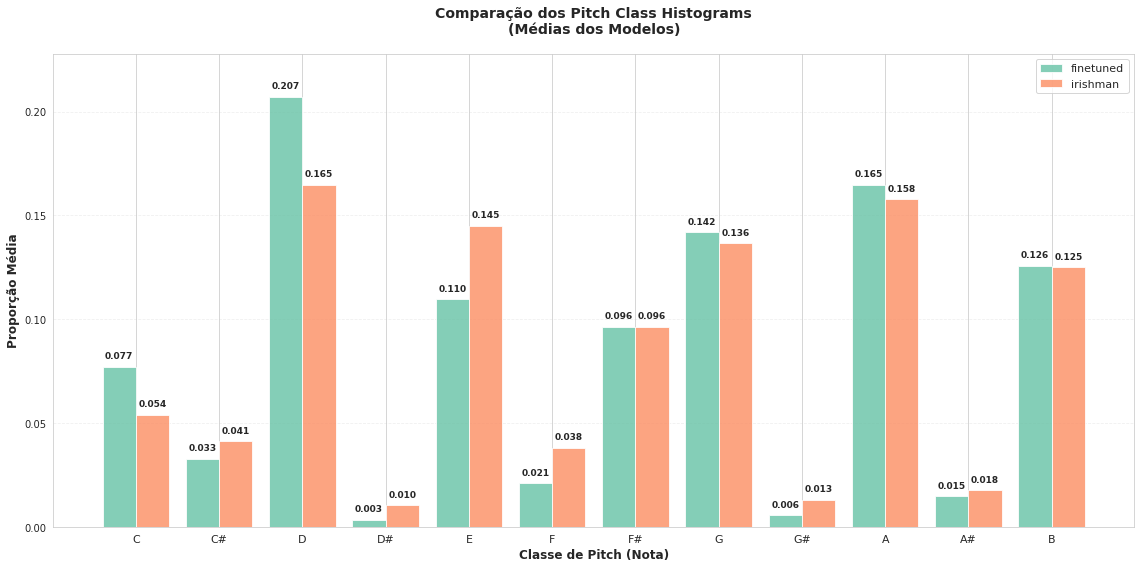

In [8]:
# Criar gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(note_labels))
width = 0.4

# Calcular médias para cada modelo
mean_hist_1 = np.mean(pitch_hist_1, axis=0)
mean_hist_2 = np.mean(pitch_hist_2, axis=0)

# Barras
bars1 = ax.bar(x - width/2, mean_hist_1, width, 
               label=MODEL_1, color='#66c2a5', alpha=0.8)
bars2 = ax.bar(x + width/2, mean_hist_2, width,
               label=MODEL_2, color='#fc8d62', alpha=0.8)

# Customização
ax.set_xlabel('Classe de Pitch (Nota)', fontsize=12, weight='bold')
ax.set_ylabel('Proporção Média', fontsize=12, weight='bold')
ax.set_title('Comparação dos Pitch Class Histograms\n(Médias dos Modelos)', 
             fontsize=14, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(note_labels, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Adicionar valores nas barras
for i, (bar1, bar2, val1, val2) in enumerate(zip(bars1, bars2, mean_hist_1, mean_hist_2)):
    if val1 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.003,
                '{:.3f}'.format(val1), ha='center', va='bottom', fontsize=9, weight='bold')
    if val2 > 0.001:  # Mostrar valores acima de 0.1%
        ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.003,
                '{:.3f}'.format(val2), ha='center', va='bottom', fontsize=9, weight='bold')

# Ajustar limite superior do eixo Y para acomodar os valores nas barras
max_height = max(np.max(mean_hist_1), np.max(mean_hist_2))
ax.set_ylim(0, max_height * 1.10)  # 10% de margem superior

plt.tight_layout()
plt.show()

#### 2. Visualização Consolidada - Radar Chart Comparativo

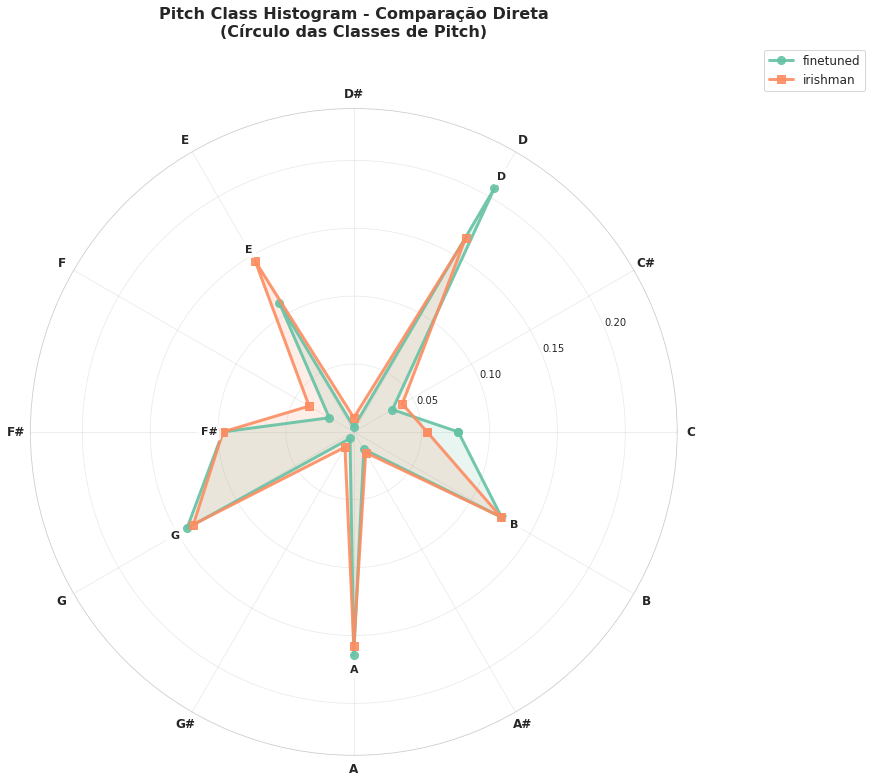

In [9]:
# Gráfico radar/spider final - comparação direta dos dois modelos
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

# Ângulos para as 12 notas (melhor organização visual)
angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)

# Fechar o polígono (repetir primeiro valor no final)
angles_closed = np.concatenate([angles, [angles[0]]])
values_1_closed = np.concatenate([mean_hist_1, [mean_hist_1[0]]])
values_2_closed = np.concatenate([mean_hist_2, [mean_hist_2[0]]])

# Plot dos dois modelos
ax.plot(angles_closed, values_1_closed, 'o-', linewidth=3, 
        label=MODEL_1, color='#66c2a5', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_1_closed, alpha=0.15, color='#66c2a5')

ax.plot(angles_closed, values_2_closed, 's-', linewidth=3, 
        label=MODEL_2, color='#fc8d62', markersize=8, alpha=0.9)
ax.fill(angles_closed, values_2_closed, alpha=0.15, color='#fc8d62')

# Customização
ax.set_xticks(angles)
ax.set_xticklabels(note_labels, fontsize=12, weight='bold')
ax.set_title('Pitch Class Histogram - Comparação Direta\n(Círculo das Classes de Pitch)', 
             fontsize=16, weight='bold', pad=40)
ax.grid(True, alpha=0.4)
ax.set_ylim(0, max(np.max(mean_hist_1), np.max(mean_hist_2)) * 1.15)

# Legenda
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

# Adicionar valores nos pontos principais (apenas os maiores valores)
max_indices = np.argsort(mean_hist_1 + mean_hist_2)[-6:]  # top 6
for i in max_indices:
    angle = angles[i]
    val1, val2 = mean_hist_1[i], mean_hist_2[i]
    max_val = max(val1, val2)
    
    # Texto do lado externo do círculo
    radius_text = max_val + max(np.max(mean_hist_1), np.max(mean_hist_2)) * 0.05
    ax.text(angle, radius_text, '{}'.format(note_labels[i]), 
           ha='center', va='center', fontsize=11, weight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Feature: `pitch_class_transition_matrix`

## Visão Geral

A função `pitch_class_transition_matrix` é uma ferramenta de análise musical que calcula uma **matriz de transição de classes de altura** (pitch class transition matrix). Esta função está localizada na linha 243 do arquivo `core.py` e é fundamental para análise de padrões harmônicos e melódicos em dados MIDI.

## Definição

Uma matriz de transição de classes de altura é uma representação bidimensional semelhante a um histograma que conta as transições de altura para cada par ordenado de notas. As classes de altura representam as 12 notas musicais cromáticas (C, C#, D, D#, E, F, F#, G, G#, A, A#, B), independentemente da oitava em que são tocadas.

## Assinatura da Função

```python
def pitch_class_transition_matrix(self, feature, normalize=0):
```

### Parâmetros

- **`feature`**: Dicionário contendo dados musicais com um objeto `pretty_midi`
- **`normalize`**: Parâmetro de normalização (padrão: 0)
  - `0`: Retorna a matriz sem normalização (contagens absolutas)
  - `1`: Normaliza por linha (cada linha soma 1)
  - `2`: Normaliza pela soma total da matriz (toda matriz soma 1)

### Retorno

- **`transition_matrix`**: Matriz numpy de forma [12, 12] representando as transições entre classes de altura

## Como Funciona

1. **Extração dos dados**: A função obtém o objeto `pretty_midi` dos dados de entrada
2. **Cálculo da matriz**: Chama o método `get_pitch_class_transition_matrix()` que:
   - Analisa sequencialmente as notas na música
   - Conta quantas vezes cada classe de altura é seguida por outra
   - Constrói uma matriz 12×12 onde `matriz[i][j]` = número de vezes que a nota `i` foi seguida pela nota `j`
3. **Normalização**: Aplica o tipo de normalização especificado

## Tipos de Normalização

### Sem Normalização (normalize=0)
```python
return transition_matrix
```
Retorna as contagens brutas das transições.

### Normalização por Linha (normalize=1)
```python
sums = np.sum(transition_matrix, axis=1)
sums[sums == 0] = 1
return transition_matrix / sums.reshape(-1, 1)
```
Cada linha da matriz soma 1, representando probabilidades condicionais de transição a partir de cada nota.

### Normalização Global (normalize=2)
```python
return transition_matrix / sum(sum(transition_matrix))
```
Toda a matriz soma 1, representando a distribuição de probabilidade conjunta das transições.

## Aplicações Musicais

### 1. Detecção de Tonalidade
Diferentes tonalidades produzem padrões característicos de transição. Por exemplo:
- **Dó Maior**: Mais transições entre C-D, D-E, E-F, F-G, G-A, A-B, B-C
- **Dó menor**: Padrões diferentes envolvendo E♭, A♭, B♭

### 2. Reconhecimento de Acordes
Progressões harmônicas comuns criam assinaturas específicas:
- **I-V-vi-IV**: Produz padrões de transição característicos
- **ii-V-I**: Gera sequências previsíveis na matriz

### 3. Análise de Gênero Musical
Diferentes estilos musicais apresentam padrões distintos:
- **Jazz**: Transições cromáticas mais frequentes
- **Folk/Pop**: Transições diatônicas predominantes
- **Música atonal**: Distribuição mais uniforme

## Exemplo Prático

Para uma melodia simples em Dó Maior: `C-D-E-F-G-A-B-C`

A matriz de transição teria valores não-zero nas posições:
- `[0,2]`: C→D (1 transição)
- `[2,4]`: D→E (1 transição)  
- `[4,5]`: E→F (1 transição)
- `[5,7]`: F→G (1 transição)
- `[7,9]`: G→A (1 transição)
- `[9,11]`: A→B (1 transição)
- `[11,0]`: B→C (1 transição)

## Interpretação dos Resultados

### Matriz Normalizada por Linha
- Cada elemento `[i,j]` representa: "Dado que acabei de tocar a nota `i`, qual a probabilidade de tocar a nota `j` em seguida?"
- Útil para análise de padrões melódicos e harmônicos

### Matriz Normalizada Globalmente  
- Cada elemento representa a frequência relativa de cada tipo de transição no contexto da peça inteira
- Útil para comparação entre diferentes peças musicais

## Considerações Técnicas

- A matriz sempre terá dimensões 12×12, correspondendo às 12 classes de altura cromáticas
- Valores na diagonal principal representam repetições da mesma nota
- A soma das linhas na normalização por linha sempre será 1 (exceto para linhas totalmente vazias)
- A função trata casos especiais onde não há transições a partir de certas notas

## Limitações

1. **Perda de informação temporal**: A matriz não preserva informação sobre timing ou duração
2. **Redução de oitavas**: Todas as notas são reduzidas às suas classes de altura (C1, C4, C7 → C)
3. **Contexto harmônico**: Não distingue entre diferentes contextos harmônicos da mesma transição

Esta ferramenta é essencial para análise computacional de música, fornecendo uma representação compacta e matematicamente tratável dos padrões de altura em composições musicais.

In [10]:
# Explorar os dados da pitch_class_transition_matrix
transition_1 = set1_loaded_results['pitch_class_transition_matrix']
transition_2 = set2_loaded_results['pitch_class_transition_matrix']

print("Shape do {}: {}".format(MODEL_1, transition_1.shape))
print("Shape do {}: {}".format(MODEL_2, transition_2.shape))
print("\nPrimeiro exemplo {} (original):".format(MODEL_1))
print(transition_1[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_1, np.sum(transition_1[0])))

print("\nPrimeiro exemplo {} (original):".format(MODEL_2))
print(transition_2[0])
print("Soma da primeira matriz {}: {:.4f}".format(MODEL_2, np.sum(transition_2[0])))

# Verificar se há valores significativos
print("\nEstatísticas básicas:")
print("{} - valores não-zero: {:.1f}%, máximo: {:.4f}".format(
    MODEL_1, np.mean(transition_1 > 0) * 100, np.max(transition_1)))
print("{} - valores não-zero: {:.1f}%, máximo: {:.4f}".format(
    MODEL_2, np.mean(transition_2 > 0) * 100, np.max(transition_2)))

Shape do finetuned: (93, 12, 12)
Shape do irishman: (93, 12, 12)

Primeiro exemplo finetuned (original):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 8. 0. 0. 0. 1. 0. 0. 3. 0. 8.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 3. 0. 6. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 5. 0. 0. 0. 2. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 3. 0. 5.]]
Soma da primeira matriz finetuned: 63.0000

Primeiro exemplo irishman (original):
[[ 0.  0.  0.  0. 10.  0.  0.  0.  0. 14.  0. 12.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  6.  0. 10.  0.  0.  4.  0.  0.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [10.  0. 16.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  6.  0.  0. 28.  0. 

In [11]:
# Preparar dados para visualização
from matplotlib.gridspec import GridSpec

# Calcular matrizes médias normalizadas por linha (probabilidades de transição)
def normalize_transition_matrix(matrix):
    """Normaliza matriz de transição por linha (probabilidades condicionais)"""
    normalized = matrix.copy()
    row_sums = np.sum(matrix, axis=2, keepdims=True)
    row_sums[row_sums == 0] = 1  # Evitar divisão por zero
    normalized = matrix / row_sums
    return normalized

# Normalizar todas as matrizes
transition_1_norm = normalize_transition_matrix(transition_1)
transition_2_norm = normalize_transition_matrix(transition_2)

# Calcular médias
mean_transition_1 = np.mean(transition_1_norm, axis=0)
mean_transition_2 = np.mean(transition_2_norm, axis=0)

# Calcular diferença (Model1 - Model2)
diff_matrix = mean_transition_1 - mean_transition_2

# Labels das notas
note_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

print("Preparação concluída!")
print("Matriz média {} - valores não-zero: {:.1f}%".format(
    MODEL_1, np.mean(mean_transition_1 > 0.001) * 100))
print("Matriz média {} - valores não-zero: {:.1f}%".format(
    MODEL_2, np.mean(mean_transition_2 > 0.001) * 100))

Preparação concluída!
Matriz média finetuned - valores não-zero: 78.5%
Matriz média irishman - valores não-zero: 88.2%


#### 1. Heatmaps Comparativos - Matrizes de Transição Médias

Os heatmaps mostram as **probabilidades de transição condicionais**: dado que tocamos a nota da linha, qual a probabilidade de tocar a nota da coluna em seguida.

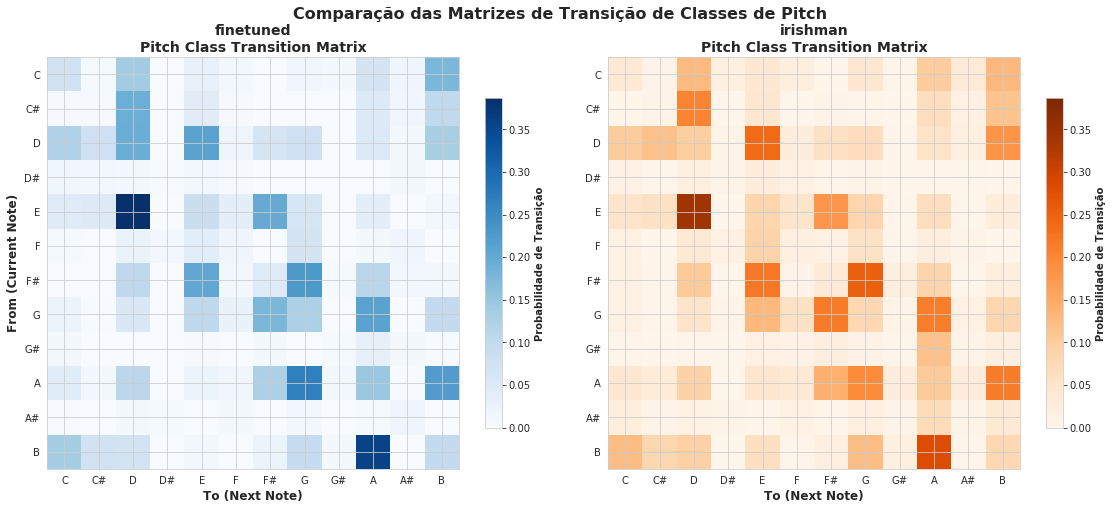

In [ ]:
# 1. Heatmaps comparativos das matrizes de transição
fig = plt.figure(figsize=(16, 7))  # Aumentei a altura da figura
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Definir escala comum para comparação
vmax = max(np.max(mean_transition_1), np.max(mean_transition_2))
vmin = 0

# Subplot 1: Model 1
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(mean_transition_1, cmap='Blues', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax1.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_1), fontsize=14, weight='bold')
ax1.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax1.set_ylabel('From (Current Note)', fontsize=12, weight='bold')
ax1.set_xticks(range(12))
ax1.set_yticks(range(12))
ax1.set_xticklabels(note_labels, fontsize=10)
ax1.set_yticklabels(note_labels, fontsize=10)

# Subplot 2: Model 2
ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(mean_transition_2, cmap='Oranges', aspect='equal', 
                 vmin=vmin, vmax=vmax, interpolation='nearest')
ax2.set_title('{}\nPitch Class Transition Matrix'.format(MODEL_2), fontsize=14, weight='bold')
ax2.set_xlabel('To (Next Note)', fontsize=12, weight='bold')
ax2.set_ylabel('')
ax2.set_xticks(range(12))
ax2.set_yticks(range(12))
ax2.set_xticklabels(note_labels, fontsize=10)
ax2.set_yticklabels(note_labels, fontsize=10)

# Colorbars
cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.set_label('Probabilidade de Transição', fontsize=10, weight='bold')
cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.set_label('Probabilidade de Transição', fontsize=10, weight='bold')

plt.suptitle('Comparação das Matrizes de Transição de Classes de Pitch', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

#### 2. Visualização em Rede das Transições Principais

Esta visualização mostra as transições como uma rede de conexões entre as notas, onde a espessura das setas representa a probabilidade de transição:

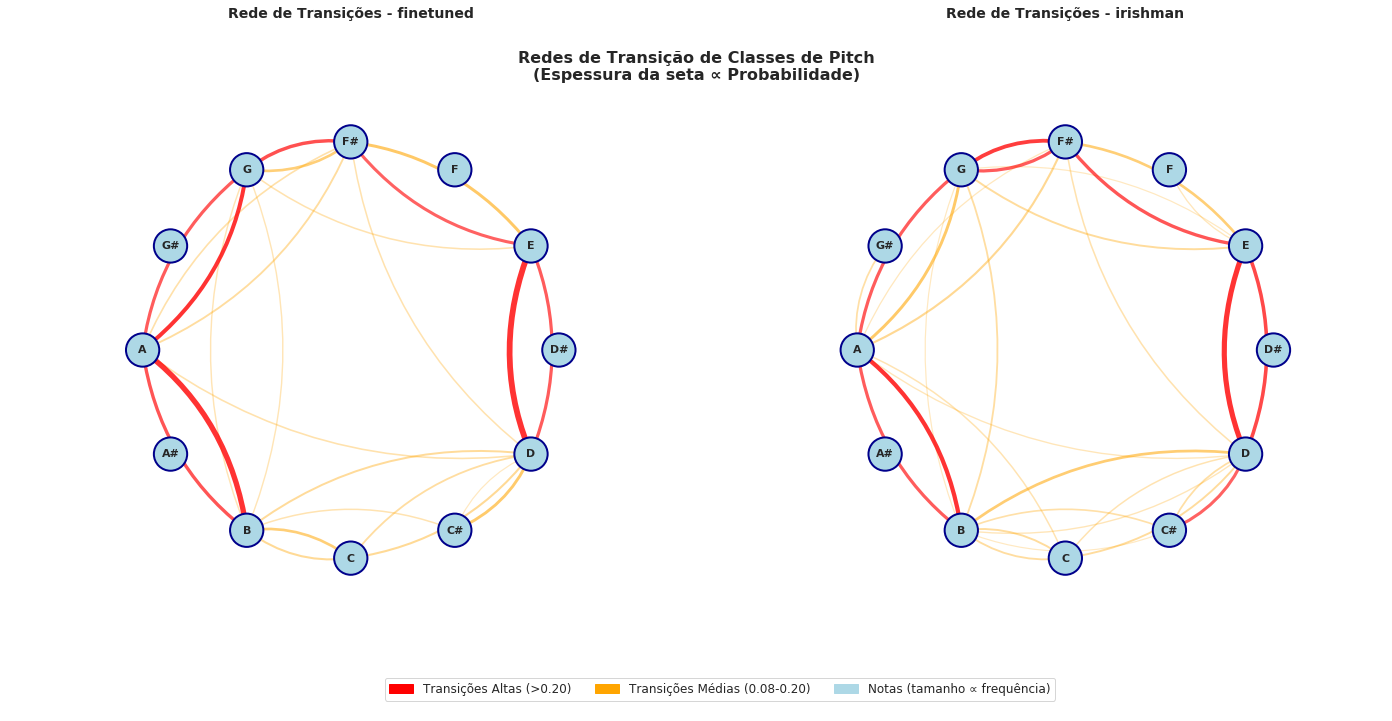

In [13]:
# 3. Visualização em rede das transições (círculo das quintas adaptado)
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

def plot_transition_network(matrix, title, ax, threshold=0.08):
    """Plota rede de transições em layout circular"""
    
    # Posições das notas em círculo (ordem cromática)
    angles = np.linspace(0, 2*np.pi, 12, endpoint=False)
    angles = angles - np.pi/2  # Começar no topo (C)
    
    radius = 1.0
    positions = {}
    for i, note in enumerate(note_labels):
        x = radius * np.cos(angles[i])
        y = radius * np.sin(angles[i])
        positions[note] = (x, y)
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    
    # Desenhar nós (notas)
    for note, (x, y) in positions.items():
        # Tamanho do nó baseado na frequência total de uso
        note_idx = note_labels.index(note)
        total_from = np.sum(matrix[note_idx, :])
        total_to = np.sum(matrix[:, note_idx])
        node_size = (total_from + total_to) * 1000 + 300
        
        circle = plt.Circle((x, y), 0.08, color='lightblue', 
                          ec='darkblue', linewidth=2, zorder=3)
        ax.add_patch(circle)
        ax.text(x, y, note, ha='center', va='center', 
                fontsize=11, weight='bold', zorder=4)
    
    # Desenhar arestas (transições acima do threshold)
    for i in range(12):
        for j in range(12):
            if matrix[i, j] > threshold and i != j:  # Não mostrar auto-loops
                from_note = note_labels[i]
                to_note = note_labels[j]
                
                x1, y1 = positions[from_note]
                x2, y2 = positions[to_note]
                
                # Calcular ponto de controle para curva
                mid_x = (x1 + x2) / 2
                mid_y = (y1 + y2) / 2
                
                # Distância do centro para criar curvatura
                center_dist = np.sqrt(mid_x**2 + mid_y**2)
                if center_dist > 0:
                    # Curvar para fora do círculo
                    curve_factor = 0.3
                    ctrl_x = mid_x + (mid_x/center_dist) * curve_factor
                    ctrl_y = mid_y + (mid_y/center_dist) * curve_factor
                else:
                    ctrl_x, ctrl_y = mid_x, mid_y
                
                # Espessura da linha proporcional à probabilidade
                line_width = matrix[i, j] * 15
                alpha = min(0.8, matrix[i, j] * 3)
                
                # Desenhar seta curvada
                arrow = mpatches.FancyArrowPatch(
                    (x1, y1), (x2, y2),
                    connectionstyle="arc3,rad=0.2",
                    arrowstyle='->', 
                    mutation_scale=15,
                    linewidth=line_width,
                    color='red' if matrix[i, j] > 0.2 else 'orange',
                    alpha=alpha,
                    zorder=2
                )
                ax.add_patch(arrow)
    
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    ax.axis('off')

# Criar figura com duas redes lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plot_transition_network(mean_transition_1, 
                       'Rede de Transições - {}'.format(MODEL_1), 
                       ax1, threshold=0.08)

plot_transition_network(mean_transition_2, 
                       'Rede de Transições - {}'.format(MODEL_2), 
                       ax2, threshold=0.08)

# Legenda
legend_elements = [
    mpatches.Patch(color='red', label='Transições Altas (>0.20)'),
    mpatches.Patch(color='orange', label='Transições Médias (0.08-0.20)'),
    mpatches.Patch(color='lightblue', label='Notas (tamanho ∝ frequência)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          fontsize=12, bbox_to_anchor=(0.5, 0.02))

plt.suptitle('Redes de Transição de Classes de Pitch\n(Espessura da seta ∝ Probabilidade)', 
             fontsize=16, weight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

In [21]:
# Sumário das principais diferenças entre os modelos

print("="*80)
print("SUMÁRIO: ANÁLISE DE TRANSIÇÕES DE CLASSES DE PITCH")
print("="*80)

# 1. Calcular diferenças absolutas entre as matrizes
diff_matrix = np.abs(mean_transition_1 - mean_transition_2)

# Encontrar as maiores diferenças
flat_diff = diff_matrix.flatten()
sorted_indices = np.argsort(flat_diff)[::-1]

print("\n1. MAIORES DIFERENÇAS ENTRE OS MODELOS (Top 10)")
print("-" * 60)
for i in range(10):
    idx = sorted_indices[i]
    from_note = idx // 12
    to_note = idx % 12
    diff = diff_matrix[from_note, to_note]
    prob1 = mean_transition_1[from_note, to_note]
    prob2 = mean_transition_2[from_note, to_note]
    
    print("{:>3} → {:<3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note_labels[from_note], note_labels[to_note], 
        MODEL_1, prob1, MODEL_2, prob2, diff))

# 2. Análise das notas mais utilizadas (diagonal principal)
print("\n2. REPETIÇÃO DE NOTAS (Diagonal Principal)")
print("-" * 60)
diag_1 = np.diag(mean_transition_1)
diag_2 = np.diag(mean_transition_2)

for i, note in enumerate(note_labels):
    print("{:>3}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        note, MODEL_1, diag_1[i], MODEL_2, diag_2[i], 
        abs(diag_1[i] - diag_2[i])))

# 3. Estatísticas gerais
entropy_1 = -np.sum(mean_transition_1 * np.log2(mean_transition_1 + 1e-10))
entropy_2 = -np.sum(mean_transition_2 * np.log2(mean_transition_2 + 1e-10))

print("\n3. ESTATÍSTICAS GERAIS")
print("-" * 60)
print("Entropia das transições:")
print("  {}: {:.3f}".format(MODEL_1, entropy_1))
print("  {}: {:.3f}".format(MODEL_2, entropy_2))
print("  Diferença: {:.3f}".format(abs(entropy_1 - entropy_2)))

# 4. Análise de intervalos musicais
intervals = {
    'Unísono': [0], 'Semitom': [1, 11], 'Tom': [2, 10], 
    'Terça menor': [3, 9], 'Terça maior': [4, 8], 'Quarta': [5, 7], 'Trítono': [6]
}

print("\n4. ANÁLISE POR INTERVALOS MUSICAIS")
print("-" * 60)
for interval_name, semitones in intervals.items():
    sum_1 = sum_2 = 0
    count = 0
    for i in range(12):
        for j in range(12):
            interval = (j - i) % 12
            if interval in semitones:
                sum_1 += mean_transition_1[i, j]
                sum_2 += mean_transition_2[i, j]
                count += 1
    
    avg_1 = sum_1 / count if count > 0 else 0
    avg_2 = sum_2 / count if count > 0 else 0
    print("{:>12}: {} = {:.3f} | {} = {:.3f} | Diff = {:.3f}".format(
        interval_name, MODEL_1, avg_1, MODEL_2, avg_2, 
        abs(avg_1 - avg_2)))

print("="*80)
print("CONCLUSÕES:")
print("- As diferenças mais significativas mostram padrões composicionais distintos")
print("- A análise de intervalos revela preferências harmônicas diferentes")
print("- As redes de transição visualizam as 'assinaturas' musicais de cada modelo")
print("="*80)

SUMÁRIO: ANÁLISE DE TRANSIÇÕES DE CLASSES DE PITCH

1. MAIORES DIFERENÇAS ENTRE OS MODELOS (Top 10)
------------------------------------------------------------
  D → D  : finetuned = 0.193 | irishman = 0.099 | Diff = 0.094
 G# → A  : finetuned = 0.030 | irishman = 0.116 | Diff = 0.086
  B → A  : finetuned = 0.356 | irishman = 0.282 | Diff = 0.074
  A → G  : finetuned = 0.266 | irishman = 0.196 | Diff = 0.071
 A# → A  : finetuned = 0.005 | irishman = 0.070 | Diff = 0.065
  B → E  : finetuned = 0.010 | irishman = 0.063 | Diff = 0.053
  D → B  : finetuned = 0.132 | irishman = 0.183 | Diff = 0.050
  G → G  : finetuned = 0.127 | irishman = 0.077 | Diff = 0.050
  C → B  : finetuned = 0.177 | irishman = 0.128 | Diff = 0.049
  F → E  : finetuned = 0.042 | irishman = 0.089 | Diff = 0.047

2. REPETIÇÃO DE NOTAS (Diagonal Principal)
------------------------------------------------------------
  C: finetuned = 0.075 | irishman = 0.037 | Diff = 0.038
 C#: finetuned = 0.004 | irishman = 0.007 | Dif